## This notebook plots figure15, which shows the sensitivity analysis of the thermal model

In [2]:
%pylab notebook
import os, sys
sys.path.append('lib/')
import pandas as pd, hts_fitting as hts, default_figure_style as dfs, hts_fitfunctions as ff
from scipy.optimize import curve_fit

energy, tape = 150, 'f29'

directory = '../data/fem/{}-1/{}keV/'.format(tape, energy)
fpaths = [directory+f for f in os.listdir(directory) if f.split('.')[-1] == 'txt']
names = ['iop', 'hKapton', 'xSensor', 'tREBCO', 'tSensor']

data = pd.read_csv(fpaths[0], names=names, skiprows=5, delim_whitespace=True)
for fpath in fpaths[1:]:
    df = pd.read_csv(fpath, names=names, skiprows=5, delim_whitespace=True)
    data = pd.concat([data, df], ignore_index=True)

########## Load data ############
#################################
masterfile = '../data/data-master-linear.xlsx'
cols = [0, 1, 12, 13, 14, 41, 43, 45, 52, 55, 56, 59]
names = ['tapeid', 'anneal', 'energy', 'power', 'powerError', 'tTAR_OFF', 'tHTS_ON', 'tTAR_ON', 'tREBCO', 'suppression', 'suppressionError', 'outlier']
df = pd.read_excel(masterfile, sheet_name='data', usecols=cols, names=names, skiprows=1)


########## Filter data ##########
#################################
cut = df.tTAR_OFF <= 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1
df = df[cut]

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


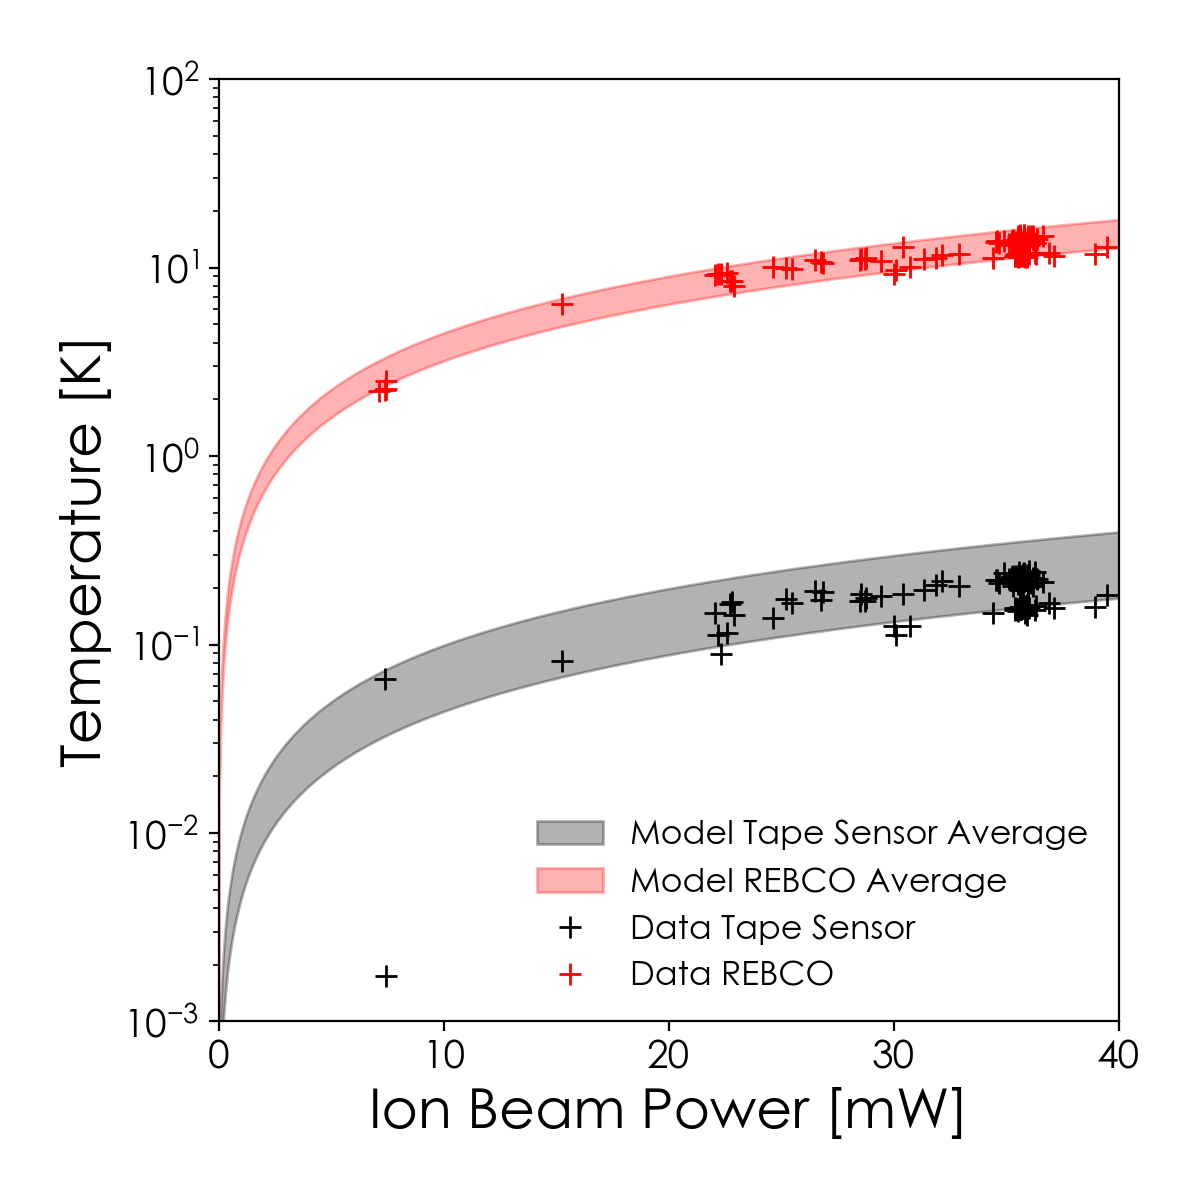

In [16]:
xsmooth = np.linspace(0, 200, 10000)
fig, ax = plt.subplots(figsize=(6, 6))

x, y1, y2 = energy*data.iop/1e3, data.tREBCO, data.tSensor

hKaptons = np.sort(data.hKapton.unique())

cut1 = (data.hKapton == hKaptons[0]) & (data.xSensor == 0.)
cut2 = (data.hKapton == hKaptons[1]) & (data.xSensor == 0.)

popttop, poptbot = [], []
cuts = [cut1, cut2]
markers = ['', 's']
labels = ['REBCO layer Max.', 'Tape Sensor Max.']

for i, (cut, m) in enumerate(zip(cuts, markers)):
    for y, fc, l in zip([y1, y2], [dfs.colors_energies[str(energy)], 'white'], labels):
        popt, pcov = curve_fit(ff.affine, x[cut], y[cut])
        if i == 0:
            poptbot.append(popt)
        elif i == 1:
            popttop.append(popt)
        else:
            ax.plot(x[cut], y[cut], linestyle='-', marker=m, markersize=4, color=ec, mec=ec, mfc=fc, label=l)

ax.fill_between(x=xsmooth, y1=ff.affine(xsmooth, *popttop[1]), y2=ff.affine(xsmooth, *poptbot[1]), alpha=.3, color='k', label='Model Tape Sensor Average')         
ax.fill_between(x=xsmooth, y1=ff.affine(xsmooth, *popttop[0]), y2=ff.affine(xsmooth, *poptbot[0]), alpha=.3, color='r', label='Model REBCO Average')         

cut = (df.tapeid == tape) & (df.anneal == 1) & (df.energy==energy)
x, y = df.power[cut], df.tHTS_ON[cut]
popt, _ = curve_fit(ff.linear, x, y)
y -= popt[1]
x = x[y >= 0]
y = y[y >= 0] # remove negative temperature, which are due to sensor fluctuations
ax.semilogy(x, y, linestyle='None', marker='+', color='k', label='Data Tape Sensor')
ax.semilogy(df.power[cut], df.tREBCO[cut]-df.tTAR_ON[cut], linestyle='None', marker='+', color='r', label='Data REBCO')

ax.set_xlim(0, 40)
ax.set_ylim(1e-3, 1e2)
ax.legend(loc='lower right', frameon=False)
ax.set_ylabel('Temperature [K]')
ax.set_xlabel('Ion Beam Power [mW]')
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'figure15-ModelSensitivity.svg', format='svg', transparent=True)

<IPython.core.display.Javascript object>


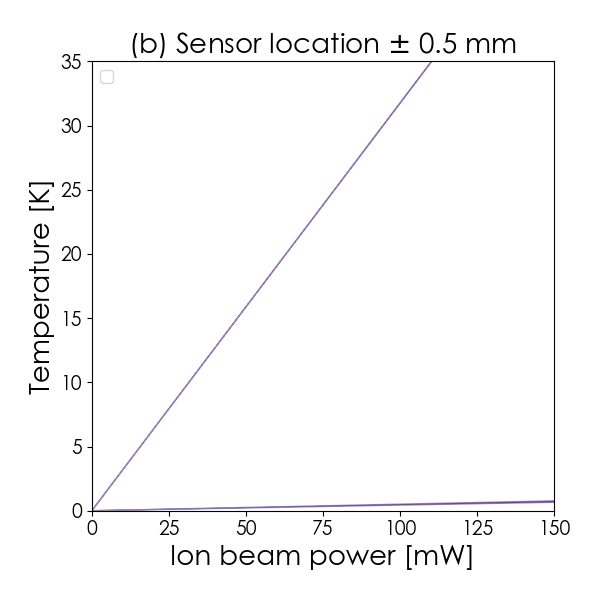

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[array([0.31710803]), array([0.00510911])] [array([0.31744981]), array([0.00437994])]


In [4]:
xsmooth = np.linspace(0, 200, 10000)
fig, ax = plt.subplots()

x, y1, y2 = energy*data.iop/1e3, data.tREBCO, data.tSensor

cut1 = (data.xSensor == data.xSensor.unique()[0]) & (data.hKapton == 1.5e-05)
cut2 = (data.xSensor == data.xSensor.unique()[1]) & (data.hKapton == 1.5e-05)

popttop, poptbot = [], []
cuts = [cut1, cut2]
markers = ['s', '']
labels = ['Max. REBCO layer', 'Max. CX-T Sensor']
for i, (cut, m) in enumerate(zip(cuts, markers)):

    for y, fc, l in zip([y1, y2], ['r', 'white'], labels):
        
        popt, pcov = curve_fit(ff.affine, x[cut], y[cut])
        if i == 0:
            poptbot.append(popt)
        elif i == 1:
            popttop.append(popt)
        else:
            ax.plot(x[cut], y[cut], linestyle='-', marker=m, markersize=4, color=ec, mec=ec, mfc=fc, label=l)

print(poptbot, popttop)

ax.fill_between(x=xsmooth, y1=ff.affine(xsmooth, *popttop[0]), y2=ff.affine(xsmooth, *poptbot[0]), alpha=.5, color=ec)         
ax.fill_between(x=xsmooth, y1=ff.affine(xsmooth, *popttop[1]), y2=ff.affine(xsmooth, *poptbot[1]), alpha=.5, color=ec)         

ax.set_ylim(0, 35)
ax.set_xlim(0, 150)
#yticks = [0.01, 0.1, 1, 10, 50]
#ax.set_yticks(yticks)
#ax.set_yticklabels([str(tick) for tick in yticks])
#ax.set_ylim(0.01, 50)
ax.set_title(r'(b) Sensor location $\pm$ 0.5 mm')
ax.set_ylabel('Temperature [K]')
ax.set_xlabel('Ion beam power [mW]')
ax.legend(loc='upper left')
fig.tight_layout()

plt.savefig(dfs.outputDirectory+'figure15-ModelSensitivity-b.svg', facecolor='white')